**Input:** Initialization Level Set 

**Loss Function:** MSE 

# Google Drive Mounting

In [0]:
from google.colab import drive

In [0]:
drive.mount('/content/drive')

# Data Generator

In [0]:
import numpy as np 
import matplotlib.pyplot as plt

In [0]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [0]:
import scipy.io         # for loading .mat ground truth files 
from PIL import Image   # for loading images to be resized 

In [0]:
eps = np.finfo(float).eps   # a small value, to avoid zero division

In [0]:
import scipy.ndimage as nd

def bwdist(mask):
    return nd.distance_transform_edt(np.logical_not(mask))

def mask2levelSet(mask):
    return bwdist(mask) - bwdist(1 - mask)

In [0]:
#!python generateMasks.py "/content/drive/My Drive/DeepLevelSet/train_images" "/content/drive/My Drive/DeepLevelSet/train_masks"

In [0]:
class Dataset(Dataset):
  def __init__(self, list_IDs):
        'Initialization'
        self.list_IDs = list_IDs
        self.base_url = "/content/drive/My Drive/DeepLevelSet"

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)

  def __getitem__(self, index):
        'Generates one sample of data'
        ID = self.list_IDs[index]
        fileName = ID.split('.')[0]                                 # name without file extension  

        X_img = Image.open(f"{self.base_url}/train_images/{ID}")    # loading image
        X_img = X_img.resize((224, 224))                            # resizing to 224x224 
        X_img = transforms.functional.to_tensor(X_img)              # PIL image to Tensor 
        
        X_mask = np.load(f"{self.base_url}/train_masks/{fileName}.npy")
        X_mask = np.where(X_mask==1, 0, 1)                          # inverting 1 and 0
        phi_init = mask2levelSet(X_mask).astype("float32")          # mask to level set
        X_mask = transforms.functional.to_tensor(phi_init)          # converting to tensor 

        X = torch.cat((X_img, X_mask), dim=0)                       # X = [X_img, X_mask]
        
        yMat = scipy.io.loadmat(f"{self.base_url}/groundTruth/{fileName}.mat")
        y = yMat['groundTruth'][0][0][0][0][0] - 1                  # fetching ground truth mask 
        y = Image.fromarray(y)                                      # converting to PIL image 
        y = y.resize((224, 224))                                    # resizing to 224x224
        y = np.asarray(y)                                           # converting back to array 
        phi_gt =  mask2levelSet(y).astype("float32")                # mask to level set

        Y = phi_init - phi_gt                                       # difference of levelsets 
        Y = Y / (np.abs(Y) + eps)                                   # normalizing 
        Y = transforms.functional.to_tensor(Y)                      # to tensor 
        Y = torch.squeeze(Y.view(-1, 1))                            # reshaping into a vector 

        return X, Y

# Model Definition

In [0]:
import torchvision.models as models

In [20]:
# loading pretrained resnet101
model = models.resnet101(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth


In [0]:
# modifying first conv layer for 4 channel input
weight_conv1 = model.conv1.weight.clone()

model.conv1 = torch.nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3, bias=False)
with torch.no_grad():
    model.conv1.weight[:, :3] = weight_conv1
    model.conv1.weight[:, 3] = model.conv1.weight[:, 0]

In [0]:
# modifying last layer 
model.fc = torch.nn.Sequential(
    torch.nn.Linear(in_features=2048, out_features=224*224),
    torch.nn.Sigmoid()
)

In [0]:
# unfreezing model layers 
for name, param in model.named_parameters():
    try:
        param.requires_grad = True
    except Exception as e: 
        print(f"{name}: {e}")

In [0]:
# loading saved weights 
# BASE_URL = "/content/drive/My Drive/DeepLevelSet"
# model.load_state_dict(torch.load(f"{BASE_URL}/Resnet_phi.pth"))

In [24]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# moving model to GPU if available
model.to(device)

ResNet(
  (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Data Loader

In [0]:
import os

In [0]:
dirs = os.listdir("/content/drive/My Drive/DeepLevelSet/train_images")
partition = {
    'train': dirs
    }

In [0]:
params = {
    'batch_size': 32,
    'shuffle': True,
    'num_workers': 6
    }

training_set = Dataset(partition['train'])
training_generator = DataLoader(training_set, **params)

# Model Training 

In [0]:
from torch import optim

In [0]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(params=model.parameters()) 

In [30]:
epochs = 300

train_losses = []
for e in range(epochs):
    running_loss = 0
    for local_batch, local_labels in training_generator:
        inputs, labels = local_batch.to(device), local_labels.to(device)
        F = model(inputs)
        loss = criterion(2*F-1, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_losses.append(running_loss/len(training_generator))

    print(f"Epoch: {e+1}/{epochs}.. Training Loss: {running_loss/len(training_generator):.4f}")

Epoch: 1/300.. Training Loss: 0.8042
Epoch: 2/300.. Training Loss: 0.7247
Epoch: 3/300.. Training Loss: 0.6852
Epoch: 4/300.. Training Loss: 0.6400
Epoch: 5/300.. Training Loss: 0.6161
Epoch: 6/300.. Training Loss: 0.6011
Epoch: 7/300.. Training Loss: 0.5839
Epoch: 8/300.. Training Loss: 0.5946
Epoch: 9/300.. Training Loss: 0.5794
Epoch: 10/300.. Training Loss: 0.5726
Epoch: 11/300.. Training Loss: 0.5572
Epoch: 12/300.. Training Loss: 0.5454
Epoch: 13/300.. Training Loss: 0.5476
Epoch: 14/300.. Training Loss: 0.5453
Epoch: 15/300.. Training Loss: 0.5631
Epoch: 16/300.. Training Loss: 0.5484
Epoch: 17/300.. Training Loss: 0.5586
Epoch: 18/300.. Training Loss: 0.5245
Epoch: 19/300.. Training Loss: 0.5105
Epoch: 20/300.. Training Loss: 0.5067
Epoch: 21/300.. Training Loss: 0.4898
Epoch: 22/300.. Training Loss: 0.4692
Epoch: 23/300.. Training Loss: 0.4578
Epoch: 24/300.. Training Loss: 0.4475
Epoch: 25/300.. Training Loss: 0.4456
Epoch: 26/300.. Training Loss: 0.4268
Epoch: 27/300.. Train

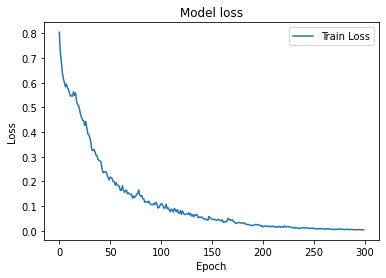

In [31]:
plt.plot(train_losses)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train Loss'])
plt.show()

In [0]:
# saving model 
BASE_URL = "/content/drive/My Drive/DeepLevelSet"

torch.save(model.state_dict(), f"{BASE_URL}/ResNet_phi.pth" )

# Visualizing Output

In [0]:
BASE_URL = "/content/drive/My Drive/DeepLevelSet"

In [0]:
def test_preprocess(img, phi): 
    X_img = transforms.functional.to_tensor(img)  # PIL image to Tensor
    X_mask = transforms.functional.to_tensor(phi.astype("float32") )    # converting to tensor 
    X = torch.cat((X_img, X_mask), dim=0)   # X = [X_img, X_mask]

    return X

In [0]:
def get_target(ID, phi_init):
    yMat = scipy.io.loadmat(f"{BASE_URL}/groundTruth/{ID}.mat")
    y = yMat['groundTruth'][0][0][0][0][0] - 1                  # fetching ground truth mask 
    y = Image.fromarray(y)                                      # converting to PIL image 
    y = y.resize((224, 224))                                    # resizing to 224x224
    y = np.asarray(y)                                           # converting back to array 
    phi_gt =  mask2levelSet(y).astype("float32")                # mask to level set

    Y = phi_init - phi_gt                                       # difference of levelsets 
    Y = Y / (np.abs(Y) + eps)                                   # normalizing 

    return Y 

In [0]:
def get_prediction(X_img, phi): 
    with torch.no_grad():
        model.eval()

        # preperaing model input 
        X = test_preprocess(X_img, phi)
        X = X.unsqueeze(0)
        X = X.to(device)
        
        # getting model prediction 
        F = 2*model(X)-1
        F = F.view(224, 224)
        F = F.cpu().numpy()

        return F

In [0]:
def plot_pred(ID):
    # reading image 
    X_img = Image.open(f"{BASE_URL}/train_images/{ID}.jpg")     # loading image
    X_img = X_img.resize((224, 224))                            # resizing to 224x224

    # reading initialization mask
    mask_init = np.load(f"{BASE_URL}/train_masks/{ID}.npy")
    mask_init = np.where(mask_init==1, 0, 1)
    phi = mask2levelSet(mask_init)                              # mask to phi 

    # getting target 
    Y = get_target(ID, phi)

    # getting model prediction 
    F = get_prediction(X_img, phi)

    # plotting results 
    plt.figure(figsize=(10, 5))
    plt.subplot(2, 2, 1).set_title("Image")
    plt.imshow(X_img, cmap='gray')

    plt.subplot(2, 2, 2).set_title("Init LS")
    plt.imshow(phi, cmap='gray')

    plt.subplot(2, 2, 3).set_title("Model Predicton")
    plt.imshow(F, cmap='gray')

    plt.subplot(2, 2, 4).set_title("Target")
    plt.imshow(Y, cmap='gray')


    # adding padding between two figures 
    plt.subplots_adjust(wspace = 0.5)
    plt.subplots_adjust(hspace = 0.5)

    # displaying figure
    plt.show()

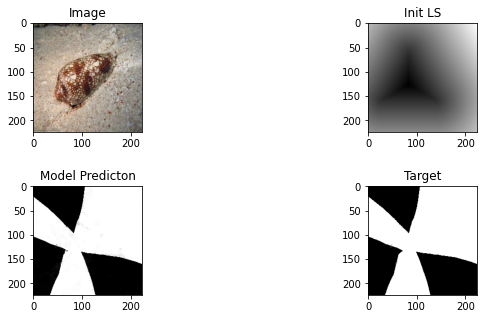

In [41]:
plot_pred(1)

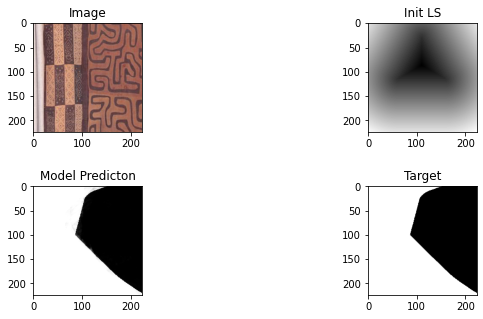

In [42]:
plot_pred(2)

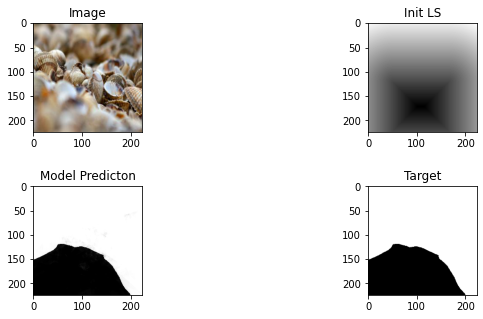

In [43]:
plot_pred(3)

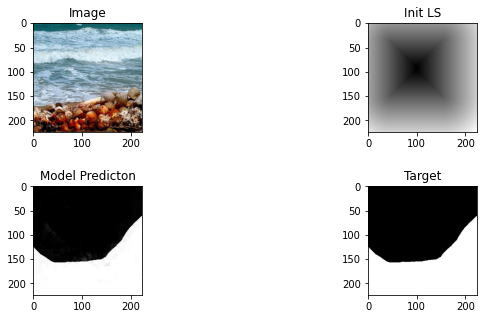

In [44]:
plot_pred(5)